In a new python environment with python>=3.10

In [52]:
print('Hello World!')
# pip3 install torch-uncertainty
# !pip install -U "torch_uncertainty[image]"

Hello World!


In [53]:
# here are the training parameters
batch_size = 10
learning_rate =1e-3
weight_decay=2e-4
lr_decay_epochs=20
lr_decay=0.1
nb_epochs=50

In [54]:
import torch
from einops import rearrange
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F

from torch_uncertainty.datasets import MUAD

train_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_set = MUAD(root="./data", target_type="semantic", version="small", split="train" , transforms=train_transform, download=True)
val_set = MUAD(root="./data", target_type="semantic", version="small", split="val" , transforms=val_transform, download=True)
test_set = MUAD(root="./data", target_type="semantic", version="small", split="test" , transforms=val_transform, download=True)

Let us see the first sample of the validation set. The first image is the input and the second image is the target (ground truth).

In [55]:
sample = train_set[0]
img, tgt = sample
img.size(), tgt.size()

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

Visualize a validation input sample (and RGB image)

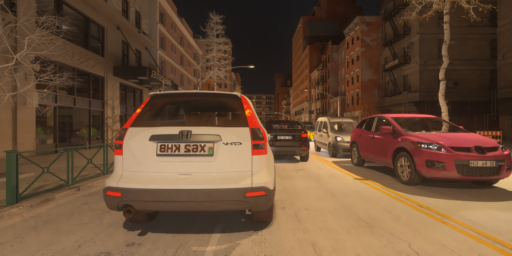

In [56]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)
F.to_pil_image(img)

Visualize the same image above but segmented (our goal)

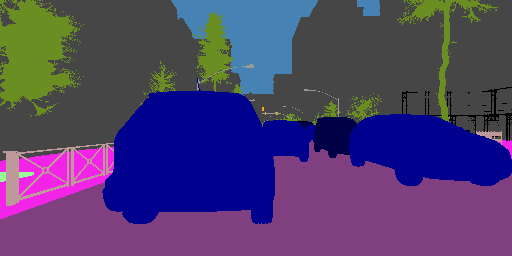

In [57]:
from torchvision.utils import draw_segmentation_masks

tmp_tgt = tgt.masked_fill(tgt == 255, 21)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, tgt_masks, alpha=1, colors=val_set.color_palette)
F.to_pil_image(img_segmented)

Below is the complete list of classes in MUAD, presented as:

1.   Class Name
2.   Train ID
3.   Segmentation Color in RGB format [R,G, B].

In [58]:
for muad_class in train_set.classes:
    class_name = muad_class.name
    train_id = muad_class.id
    color = muad_class.color
    print(f"Class: {class_name}, Train ID: {train_id}, Color: {color}")

Class: road, Train ID: 0, Color: (128, 64, 128)
Class: sidewalk, Train ID: 1, Color: (244, 35, 232)
Class: building, Train ID: 2, Color: (70, 70, 70)
Class: wall, Train ID: 3, Color: (102, 102, 156)
Class: fence, Train ID: 4, Color: (190, 153, 153)
Class: pole, Train ID: 5, Color: (153, 153, 153)
Class: traffic_light, Train ID: 6, Color: (250, 170, 30)
Class: traffic_sign, Train ID: 7, Color: (220, 220, 0)
Class: vegetation, Train ID: 8, Color: (107, 142, 35)
Class: terrain, Train ID: 9, Color: (152, 251, 152)
Class: sky, Train ID: 10, Color: (70, 130, 180)
Class: person, Train ID: 11, Color: (220, 20, 60)
Class: car, Train ID: 13, Color: (0, 0, 142)
Class: truck, Train ID: 14, Color: (0, 0, 70)
Class: bus, Train ID: 15, Color: (0, 60, 100)
Class: rider, Train ID: 12, Color: (255, 0, 0)
Class: train, Train ID: 16, Color: (0, 80, 100)
Class: motorcycle, Train ID: 17, Color: (0, 0, 230)
Class: bicycle, Train ID: 18, Color: (119, 11, 32)
Class: bear deer cow, Train ID: 19, Color: (255, 22

Here is a more comprhensive review of the diffrent classes : (while training Non-labeled data will use train ID 21 and not 255)


| **class names**                       | **ID** |
|----------------------------------------|---------|
| road                                   | 0       |
| sidewalk                               | 1       |
| building                               | 2       |
| wall                                   | 3       |
| fence                                  | 4       |
| pole                                   | 5       |
| traffic light                          | 6       |
| traffic sign                           | 7       |
| vegetation                             | 8       |
| terrain                                | 9       |
| sky                                    | 10      |
| person                                 | 11      |
| rider                                  | 12      |
| car                                    | 13      |
| truck                                  | 14      |
| bus                                    | 15      |
| train                                  | 16      |
| motorcycle                             | 17      |
| bicycle                                | 18      |
| bear deer cow                          | 19      |
| garbage_bag stand_food trash_can       | 20      |


We will feed our DNN the first raw image of the road view and as target it will be the dark image below and not the colored one (second image)

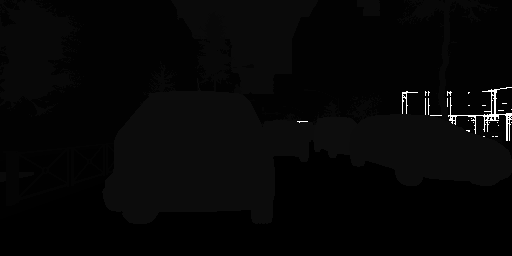

In [59]:
im = F.to_pil_image(F.to_dtype(tgt, torch.uint8))
im

In [60]:
im.size

(512, 256)

**Why is the target image dark and what's the bright part ?** **(hint : print the numpy array)**

It is the unlabeled class. Also appearing as black in the image where all the classes had different colors, with the mask applied to the unlabeled pixels.

In [61]:
print(F)

<module 'torchvision.transforms.v2.functional' from '/home/patog/university/cv/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/functional/__init__.py'>


**Q3/ please study the dataset a bit. What it is about?**

It is a synthetic dataset of urban enviroments from a perspective of a dashboard camera in a car.

In [62]:
import numpy as np
import torch
from torch.utils.data import DataLoader

train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4) # colab complained because it was bigger then 2

val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)

test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)


In [63]:
def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper.

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References:
        https://arxiv.org/abs/1606.02147

    Args:
        dataloader (``data.Dataloader``): A data loader to iterate over the
            dataset.
        num_classes (``int``): The number of classes.
        c (``int``, optional): AN additional hyper-parameter which restricts
            the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0
    for _, label in dataloader:
      label = label.cpu().numpy()
      # Flatten label
      flat_label = label.flatten()
      flat_label = flat_label[flat_label != 255]

      # Sum up the number of pixels of each class and the total pixel
      # counts for each label
      class_count += np.bincount(flat_label, minlength=num_classes)
      total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total
    return 1 / (np.log(c + propensity_score))

In [115]:
print("\nComputing class weights...")
print("(this can take a while depending on the dataset size)")
class_weights = enet_weighing(train_loader, 19)
class_weights = torch.from_numpy(class_weights).float().cuda()
print("Class weights:", class_weights)


Computing class weights...
(this can take a while depending on the dataset size)
Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444,  5.2256, 21.1894, 50.4983, 50.4983,
        50.4983, 50.4983, 50.4983], device='cuda:0')


In [65]:
class_weight_list = zip(class_weights.tolist(), [cl.name for cl in train_set.classes])
aux = 0
for wg, cl in sorted(class_weight_list):
  print(f"{aux:2} -- {cl:20} : {wg:.4f}")
  aux += 1

 0 -- building             : 3.2313
 1 -- road                 : 4.1643
 2 -- car                  : 5.2256
 3 -- vegetation           : 12.2677
 4 -- sky                  : 14.2019
 5 -- sidewalk             : 18.8984
 6 -- truck                : 21.1894
 7 -- person               : 32.0444
 8 -- pole                 : 33.8659
 9 -- fence                : 34.9159
10 -- traffic_light        : 46.7701
11 -- terrain              : 48.3328
12 -- wall                 : 48.7521
13 -- traffic_sign         : 49.3670
14 -- bicycle              : 50.4983
15 -- bus                  : 50.4983
16 -- motorcycle           : 50.4983
17 -- rider                : 50.4983
18 -- train                : 50.4983


**Q4/ why do we need to evaluate the class_weights?**

Because some classes appear much more then others, for example, cars and buidings appear much more then a traffic_sign, which, without weighting, the model would learn only about the dominant classes.

## C. building the DNN

**Q5/ Do we really use Unet? What did I change :)? (that is hard)**

It is very modified so I don't know if it still count as the U-Net oficial method. It still can be visualized like a "U" but it is using the monte carlo dropout and has padding = 1.

**Q6/Do we need a backbone with Unet?**

No, it is optional.




In [66]:
from torch import nn


class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear

        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.resize(x1, size=[2*x1.size()[2],2*x1.size()[3]],
                          interpolation=v2.InterpolationMode.BILINEAR)
        else:
            x1 = self.up(x1)

        # input is CHW
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)

#please note that we have added dropout layer to be abble to use MC dropout

class UNet(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

## D. Utility functions

In [67]:
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_accu(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of Miou")
    plt.show()

**Q7/  what is the IoU?**

Intersection over Union is a metric for semantic segmentation.

IoU = TP/(TP + FP + FN)


### Training function

**Q8/Please complete the training and the test function**

In [68]:
from torchmetrics.utilities.compute import _safe_divide


def train(model, data_loader, optim, criterion, metric,iteration_loss=False):
    model.train()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda().squeeze(1)

        # Forward propagation
        outputs = model(img)
        flatten_logits = rearrange(outputs, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255

        # Loss computation
        loss = criterion(outputs, labels)

        # Backpropagation
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of the evaluation metric
        metric.update(flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach())

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

### Validation function

In [69]:
def test(model, data_loader, criterion, metric, iteration_loss=False):
    model.eval()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda().squeeze(1)

        with torch.no_grad():
            # Forward propagation
            outputs = model(img)

            # Loss computation
            loss = criterion(outputs, labels)

            flatten_logits = rearrange(outputs, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()
            valid_mask = flatten_labels != 255

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of evaluation the metric
        metric.update(flatten_logits[valid_mask], flatten_labels[valid_mask])

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

## E. Training Process

**Q9/ please train your DNN and comment?**

It is VERY slow, even for the colab running with a nvidia T4 and I started having some warnings related to workers after a while but it doesn't impact the results so I ignored them.

For roads, sidewalk, buildings, sky and cars it is good but for the rest it really falls short.

The train mIoU is higher then the evaluation mIoU, which shows overfitting.

In [70]:
from torch import optim
from torch.optim import lr_scheduler

# this is depricated:
# from torch_uncertainty.metrics.classification import MeanIntersectionOverUnion

from torch_uncertainty.metrics.segmentation import MeanIntersectionOverUnion

print("\nTraining...\n")
num_classes = 19

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(classes=num_classes).to(device)

# We are going to use the CrossEntropyLoss loss function as it's most
# frequentely used in classification problems with multiple classes which
# fits the problem. This criterion  combines LogSoftMax and NLLLoss.
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), ignore_index=255)

optimizer = optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

scheduler = lr_scheduler.StepLR(
    optimizer,
    step_size=lr_decay_epochs,
    gamma=lr_decay
)

metric = MeanIntersectionOverUnion(num_classes=num_classes, ignore_index=255).to(device)


Training...



In [ ]:
import os

# Check if final model already exists
if os.path.exists("models/model_1_final.pth"):
    print("Found existing final model. Loading model_final.pth ...")
    model.load_state_dict(torch.load("model.pth"))
    print("Model loaded. Skipping training.")
else:
    # Start Training
    train_loss_history = []
    val_loss_history = []
    train_miou_history = []
    val_miou_history = []

    best_miou = 0.0

    for epoch in range(nb_epochs):
        print(f"\nEpoch {epoch + 1}/{nb_epochs}")

        # training
        t_loss, t_iou_class, t_miou = train(model, train_loader, optimizer, criterion, metric)
        train_loss_history.append(t_loss)
        train_miou_history.append(t_miou.item())

        # test for later plotting
        v_loss, v_iou_class, v_miou = test(model, val_loader, criterion, metric)

        val_loss_history.append(v_loss)
        val_miou_history.append(v_miou)

        print(f"Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f} | Train mIoU: {t_miou.item():.2%} | Val mIoU: {v_miou:.2%}")

        # saving
        if (epoch + 1) % 5 == 0:
            current_iou_list = v_iou_class.tolist() if isinstance(v_iou_class, torch.Tensor) else v_iou_class

            for i, muad_class in enumerate(train_set.classes):
                if i < len(current_iou_list):
                    val = current_iou_list[i]
                    if np.isnan(val):
                        print(f"{muad_class.name:15}: nan")
                    else:
                        print(f"{muad_class.name:15}: {val:.4f}")

            if v_miou > best_miou:
                best_miou = v_miou.item()
                print("\nSaving to model.pth ...\n")
                torch.save(model.state_dict(), "model.pth")

        # scheduler
        scheduler.step()


    print("Training complete.")


Epoch 1/50
Train Loss: 2.2567 | Val Loss: 2.2082 | Train mIoU: 10.26% | Val mIoU: 13.94%

Epoch 2/50
Train Loss: 1.7227 | Val Loss: 1.6664 | Train mIoU: 20.64% | Val mIoU: 18.87%

Epoch 3/50
Train Loss: 1.4393 | Val Loss: 1.3729 | Train mIoU: 24.19% | Val mIoU: 23.44%

Epoch 4/50
Train Loss: 1.2553 | Val Loss: 1.4066 | Train mIoU: 26.43% | Val mIoU: 20.18%

Epoch 5/50
Train Loss: 1.1669 | Val Loss: 1.1307 | Train mIoU: 27.83% | Val mIoU: 28.32%
road           : 0.8071
sidewalk       : 0.4379
building       : 0.7082
wall           : 0.0000
fence          : 0.2168
pole           : 0.1024
traffic_light  : 0.0000
traffic_sign   : 0.0000
vegetation     : 0.4437
terrain        : 0.0000
sky            : 0.7758
person         : 0.1274
car            : 0.6052
truck          : 0.0238
bus            : nan
rider          : nan
train          : nan
motorcycle     : nan
bicycle        : 0.0000

Saving to model.pth ...


Epoch 6/50
Train Loss: 1.0750 | Val Loss: 1.1663 | Train mIoU: 29.68% | Val mIo

Load a model

In [72]:
#Loading a model
model = UNet(num_classes)
model.load_state_dict(torch.load("model.pth"))
model = model.to("cuda")

# III. Evalution of the Trained DNN on the test

## A. classical evaluations

**Q10/ please plot the loss and miou and comment about it ?**

Both the training and test loss curves show a similar behavior but converge in different values with difference of 0.1.

There's a notable difference in the mean Intersection over Union (mIoU) values: the training mIoU reaches approximately 0.55, whereas the test mIoU plateaus at around 0.45. This discrepancy indicates some overfitting happening.

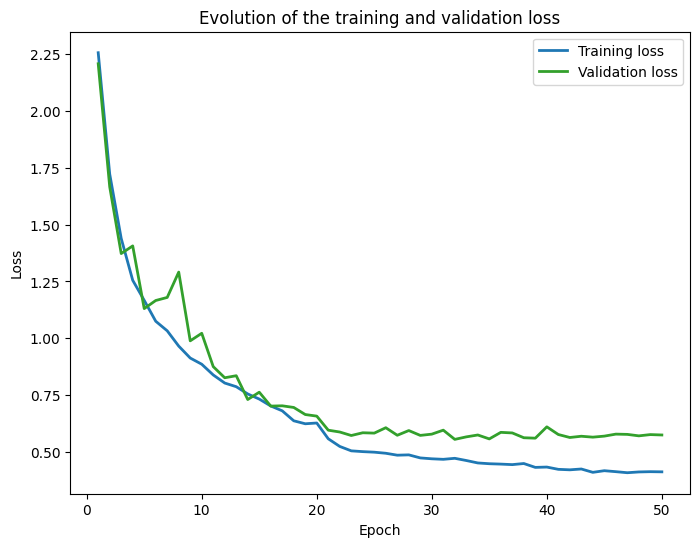

In [73]:
plot_losses(train_loss_history, val_loss_history)

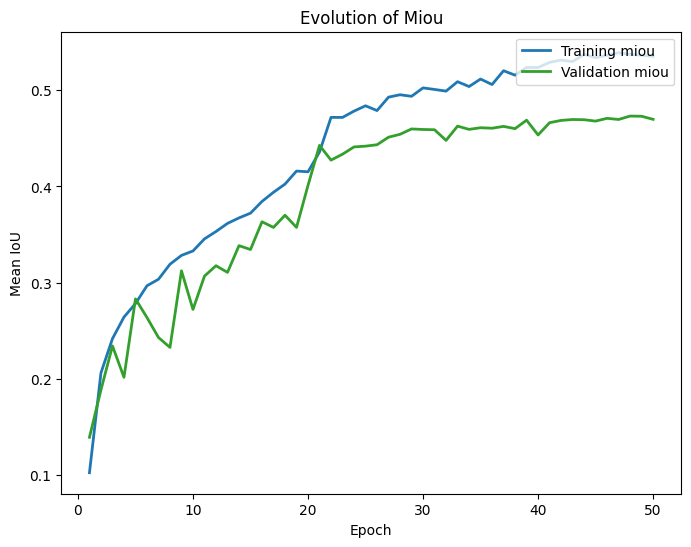

In [74]:
# plot_accu(train_miou_history, val_miou_history)
train_miou_cpu = [x.cpu().item() if isinstance(x, torch.Tensor) else x for x in train_miou_history]
val_miou_cpu = [x.cpu().item() if isinstance(x, torch.Tensor) else x for x in val_miou_history]

plot_accu(train_miou_cpu, val_miou_cpu)

**Q11/ what should we have done to avoid overfitting?**

Use distortions, transformations and noise in the images. Stop the training when validation loss stops getting better. Using backbone.

In [75]:
# Now we evaluate the model on all the test set.
loss, iou, miou = test(model, test_loader, criterion, metric)
print(">>>> [FINAL TEST on the test set: ] Avg. loss: ", loss ," | Mean IoU: ", miou)
# Print per class IoU on last epoch or if best iou
# for key, class_iou in zip(class_encoding.keys(), iou, strict=True):
for key, class_iou in zip([cl.name for cl in train_set.classes[:19]], iou, strict=True):
  print(f"{key}: {class_iou:.4f}")

>>>> [FINAL TEST on the test set: ] Avg. loss:  0.5076077058911324  | Mean IoU:  tensor(0.5093, device='cuda:0')
road: 0.9446
sidewalk: 0.7459
building: 0.8117
wall: 0.4964
fence: 0.4252
pole: 0.2457
traffic_light: 0.1680
traffic_sign: 0.0843
vegetation: 0.6040
terrain: 0.0002
sky: 0.9182
person: 0.4665
car: 0.7683
truck: 0.4515
bus: nan
rider: nan
train: nan
motorcycle: nan
bicycle: nan


## B. Uncertainty evaluations with MCP
Here you will just use as confidence score the Maximum class probability (MCP)


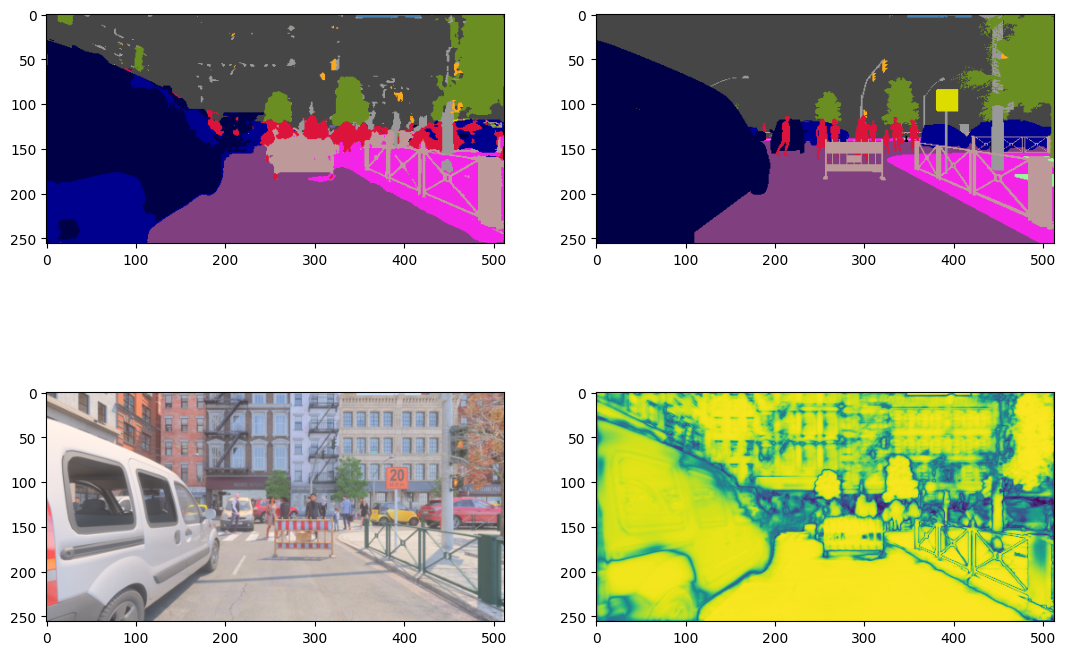

In [76]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)
	
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, ((ax3, ax2), (ax1, ax4)) = plt.subplots(2, 2, figsize=(13, 9))
ax1.imshow(img)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12/ The last image is the related to the confidence score of the DNN. Can you explain why? What does the birght areas represent and what does the dark areas represent?**

The confidence score is derived from the MCP, which is the highest value in the softmax output for each pixel.

The bright areas are where the model has hight confidance. The dark areas represent low confidence.

So, logically, in the frontier between objects, the model will be less sure of what the pixel means.

### Now let's load the OOD test set

In [77]:
test_ood_set = MUAD(root="./data", target_type="semantic", version="small", split="ood" , transforms=val_transform, download=True)
test_ood_set

Dataset MUAD
    Number of datapoints: 20
    Root location: data/MUAD_small
    Compose(
      Resize(size=[256, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [78]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

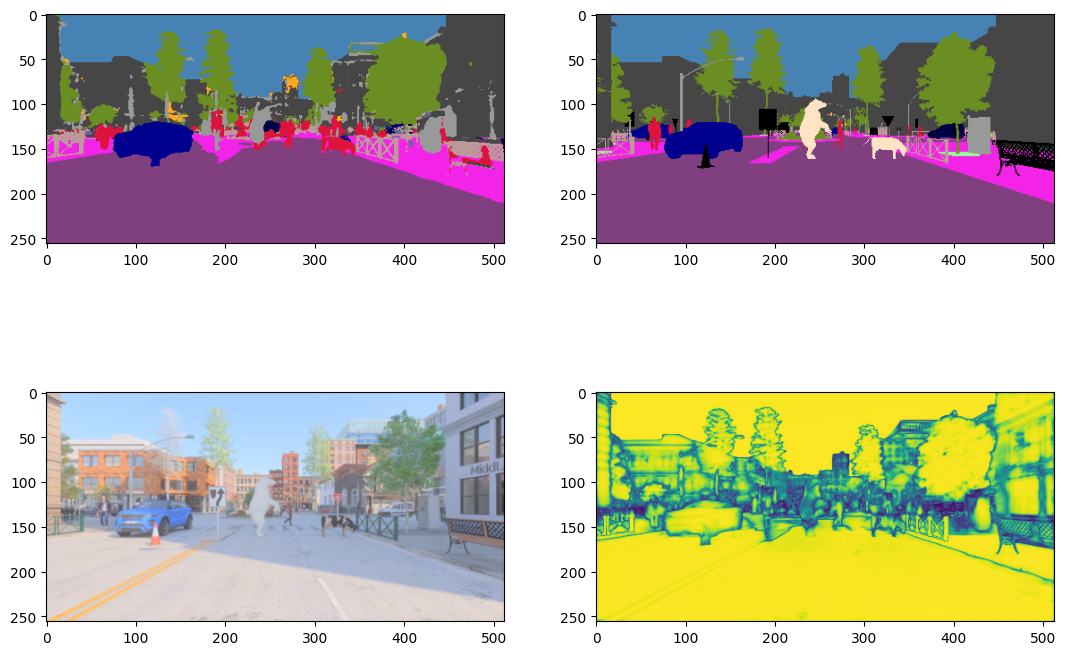

In [79]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, ((ax3, ax2), (ax1, ax4)) = plt.subplots(2, 2, figsize=(13, 9))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**According to the output is the model confident when it comes to labeling the bear and goat ? How about the bench ?**

It had low confidence with both the bear and the bench. Which is very nice as the standing bear is a very weird thing and also it had no class for benches. The goat it classified as a pedester with certain confidance.


**Q12 bis/ The last image is the related to the confidence score of the DNN. Can you explain why?**
**Are you happy with this image?**

In parts yes. It did manage to have low confidence with the bear and the bench, classified well most trees, the cars, sky, road and sidewalk. But having high confidence in the goat and treating it as a person is quite concerning.

## C. Uncertainty evaluations with Temperature Scaling
**Q13/ please implement a temperature scaling using torch_uncertainty**

Before Temprature scaling

Initial Calibration Error (ECE): 0.0237


<Figure size 800x600 with 0 Axes>

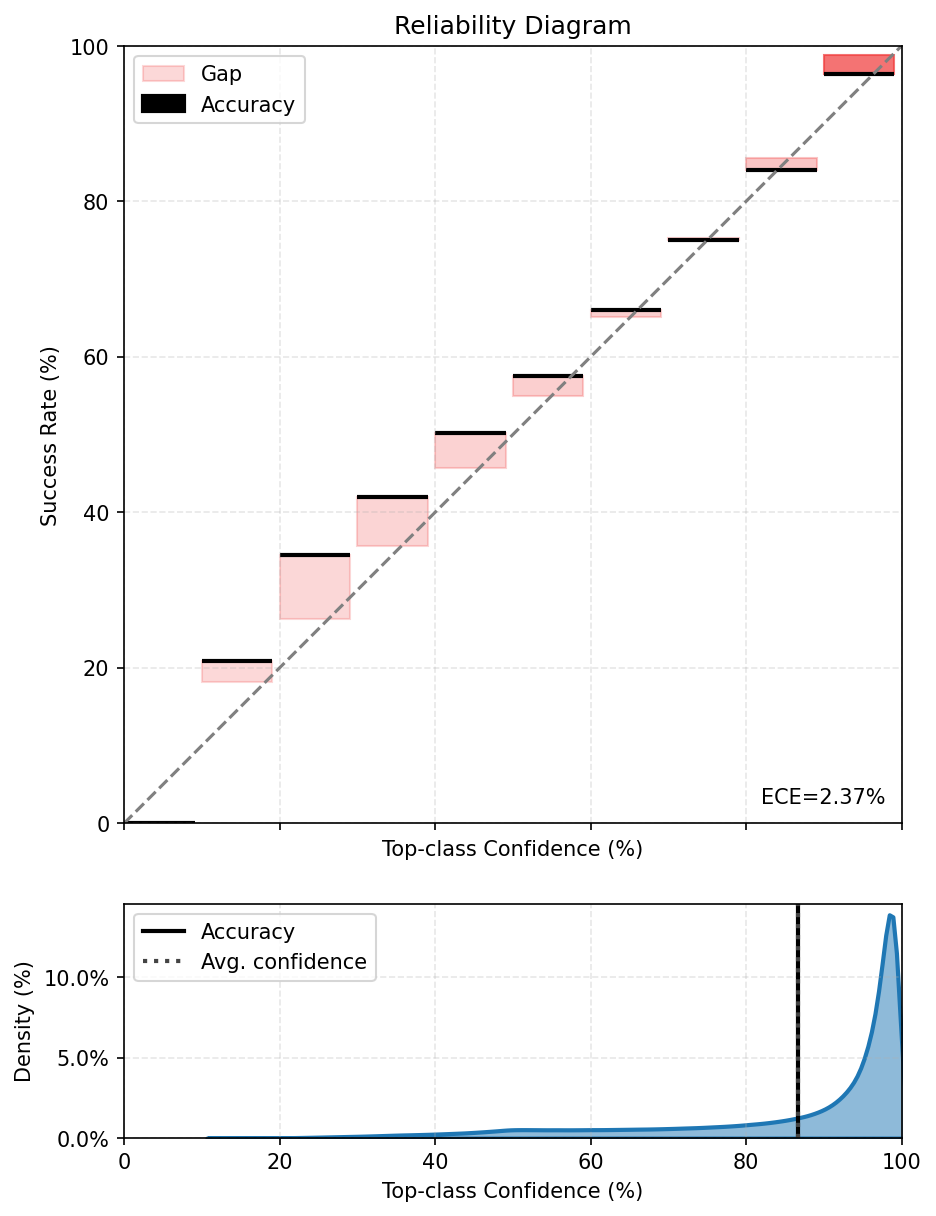

In [80]:
from torch_uncertainty.metrics import CalibrationError

cal_error = CalibrationError(task="multiclass", num_classes=num_classes, ignore_index=255).to(device)
logits_list = []
labels_list = []

print("Collecting logits from validation set...")
model.eval()

plt.figure(figsize=(8, 6))

with torch.no_grad():
    for img, label in val_loader:
        img = img.to(device)
        label = label.to(device).squeeze(1)
        
        # get raw logits (before softmax)
        out = model(img)
        
        logits_list.append(rearrange(out, "b c h w -> (b h w) c"))
        labels_list.append(label.flatten())

all_logits = torch.cat(logits_list)
all_labels = torch.cat(labels_list)

mask = all_labels != 255
valid_logits = all_logits[mask]
valid_labels = all_labels[mask]

cal_error.update(valid_logits, valid_labels)
print(f"Initial Calibration Error (ECE): {cal_error.compute().item():.4f}")
fig, ax = cal_error.plot()
plt.show()

**Seeing the two graphs above comment on the MCP unceratinty result, is the model overconfident or calibrated ?**

The model is already calibrated (1.88% ECE!) without needing post processing.

After temperature scaling

Fitting Temperature Scaler...


100%|██████████| 6831/6831 [00:33<00:00, 205.48it/s]
/home/patog/university/cv/.venv/lib/python3.12/site-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


Optimal Temperature (T): 0.9540
Scaled Calibration Error (ECE): 0.0284


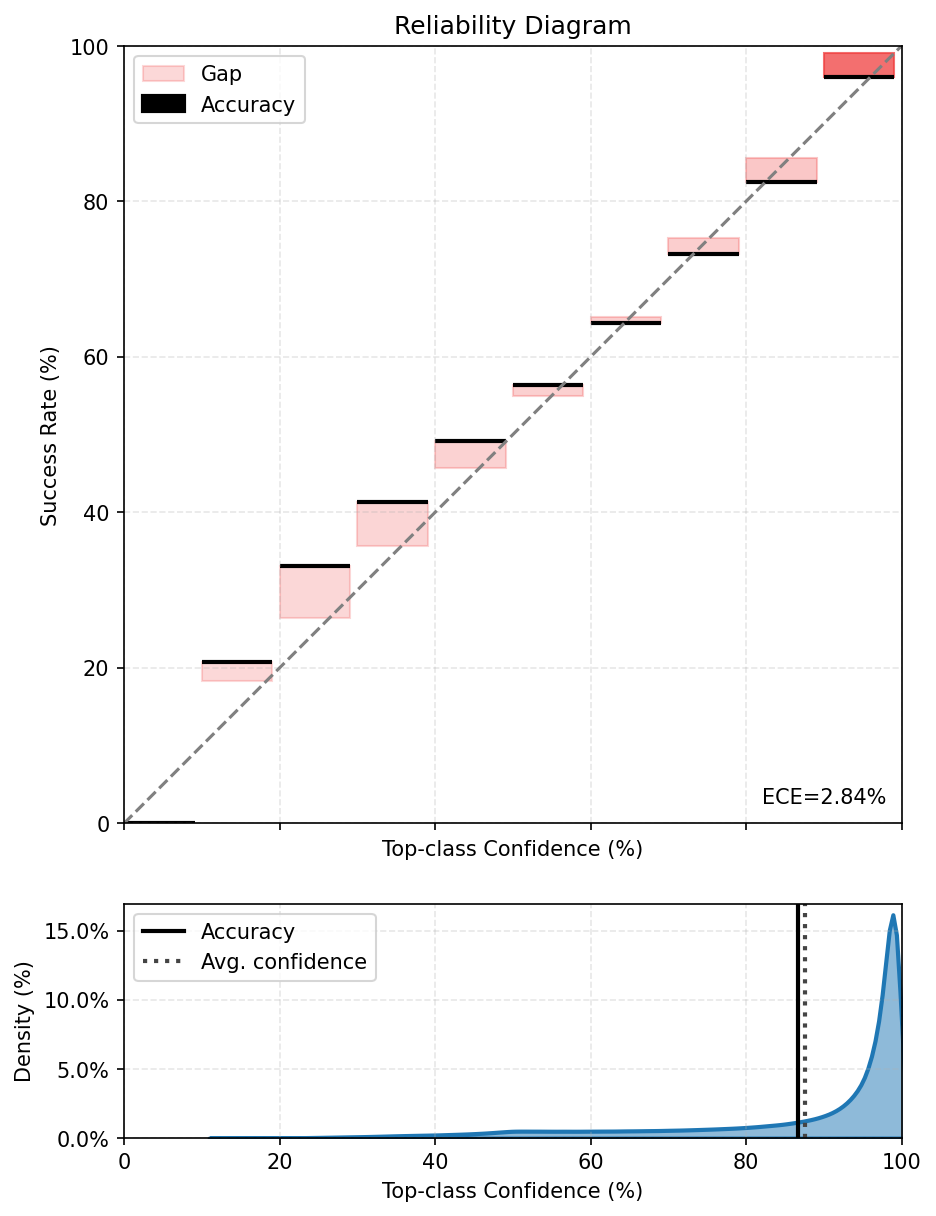

In [81]:
from torch_uncertainty.post_processing import TemperatureScaler
from torch.utils.data import TensorDataset, DataLoader

scaler = TemperatureScaler()

calibration_dataset = TensorDataset(valid_logits.cpu(), valid_labels.cpu())
calibration_loader = DataLoader(calibration_dataset, batch_size=1024, shuffle=False)

print("Fitting Temperature Scaler...")
scaler.fit(calibration_loader)
print(f"Optimal Temperature (T): {scaler.temperature[0].item():.4f}")

scaled_logits = scaler(valid_logits.cpu()).to(device)

cal_error.reset()
cal_error.update(scaled_logits, valid_labels)
print(f"Scaled Calibration Error (ECE): {cal_error.compute().item():.4f}")
fig, ax = cal_error.plot()
plt.show()

Now let's see the new confidence score image after scaling

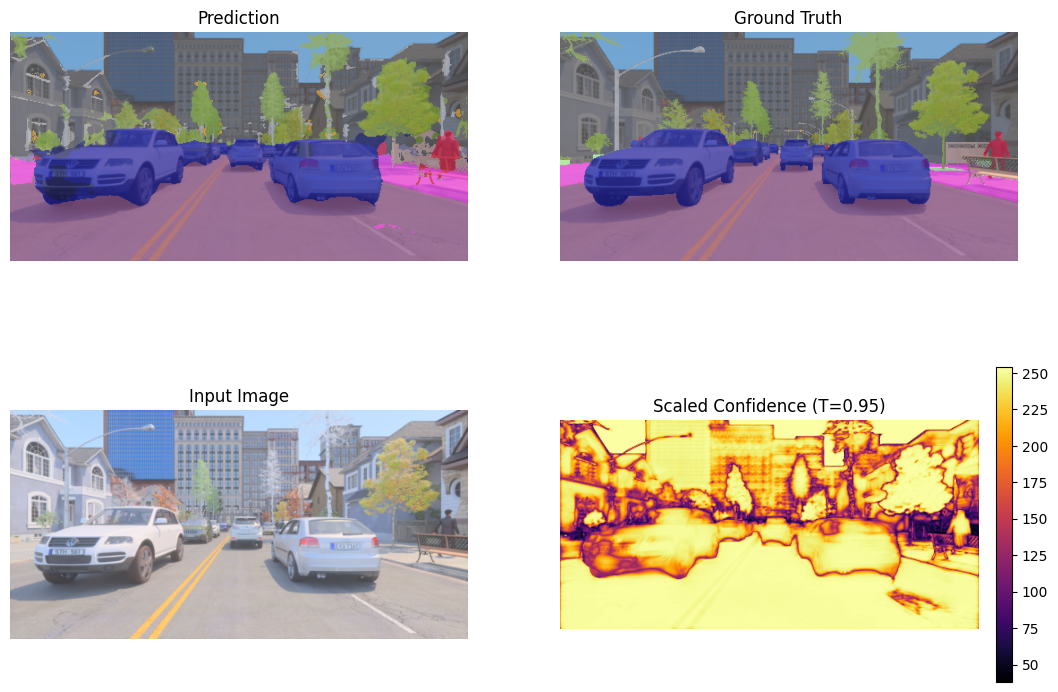

In [82]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.v2.functional as F
from einops import rearrange

img_batch, target_batch = next(iter(val_loader))

img = img_batch[0].to(device)
target = target_batch[0].to(device).squeeze(0)

model.eval()
scaler.eval()
scaler = scaler.to(device)

with torch.no_grad():
    logits = model(img.unsqueeze(0))
    
    b, c, h, w = logits.shape
    logits_flat = rearrange(logits, "b c h w -> (b h w) c")
    
    scaled_logits_flat = scaler(logits_flat)
    
    scaled_probs_flat = scaled_logits_flat.softmax(dim=1)
    scaled_probs = rearrange(scaled_probs_flat, "(b h w) c -> b c h w", b=b, h=h, w=w)
    
    confidence, pred = scaled_probs.max(dim=1)
    
    confidence = confidence.squeeze(0)
    pred = pred.squeeze(0)

mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img_disp = img * std[:, None, None] + mean[:, None, None]
img_disp = F.to_dtype(img_disp, torch.uint8, scale=True)
palette = val_set.color_palette if hasattr(val_set, 'color_palette') else None
num_classes = 19
classes_indices = torch.arange(num_classes, device=device)[:, None, None]

target_masks = target == classes_indices

pred_masks = pred == classes_indices

img_segmented = draw_segmentation_masks(img_disp, target_masks, alpha=0.6, colors=palette)
pred_img = draw_segmentation_masks(img_disp, pred_masks, alpha=0.6, colors=palette)

img_pil = F.to_pil_image(img_disp)
img_segmented_pil = F.to_pil_image(img_segmented)
pred_img_pil = F.to_pil_image(pred_img)
confidence_pil = F.to_pil_image(confidence.cpu()) 

fig, ((ax3, ax2), (ax1, ax4)) = plt.subplots(2, 2, figsize=(13, 9))

ax1.imshow(img_pil)
ax1.set_title("Input Image")
ax1.axis('off')

ax2.imshow(img_segmented_pil)
ax2.set_title("Ground Truth")
ax2.axis('off')

ax3.imshow(pred_img_pil)
ax3.set_title("Prediction")
ax3.axis('off')

cax = ax4.imshow(confidence_pil, cmap='inferno') 
ax4.set_title(f"Scaled Confidence (T={scaler.temperature[0].item():.2f})")
ax4.axis('off')

fig.colorbar(cax, ax=ax4, fraction=0.046, pad=0.04)

plt.show()

**Did the model get more confident ? or is it more calibrated ? Commnet on the temperature scaling graphs and results**

It did get more confident because the ideal temperature was > 1, which means the already high probabilities get even higher.

No, it didnt get more calibrated, actually, the opposite. The ECE got from 1.88% to 2.55%, which are still low and good numbers but it did get worst. 

From the graphs them selves, it looks like is that the temperature just distributed better the inacurracy between the classes but to be honest I'm not sure of this is just my perception of what happened or if it actually happened.

## D. Uncertainty evaluations with MC Dropout

Let us implement **MC dropout**. This technique decribed in [this paper](https://arxiv.org/abs/1506.02142) allow us to have a better confindence score by using the dropout during test time.



**Q\14 Please implement MC Dropout using torch_uncertainty**

In [ ]:
from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout

import torch
import gc

torch.cuda.empty_cache()
gc.collect()

mc_model_3 = mc_dropout(model, num_estimators=3, task="segmentation").to(device)

mc_model_20 = mc_dropout(model, num_estimators=20, task="segmentation").to(device)

mc_model_3.on_batch = False
mc_model_20.on_batch = False

print("MC Dropout models initialized.")

MC Dropout models initialized.


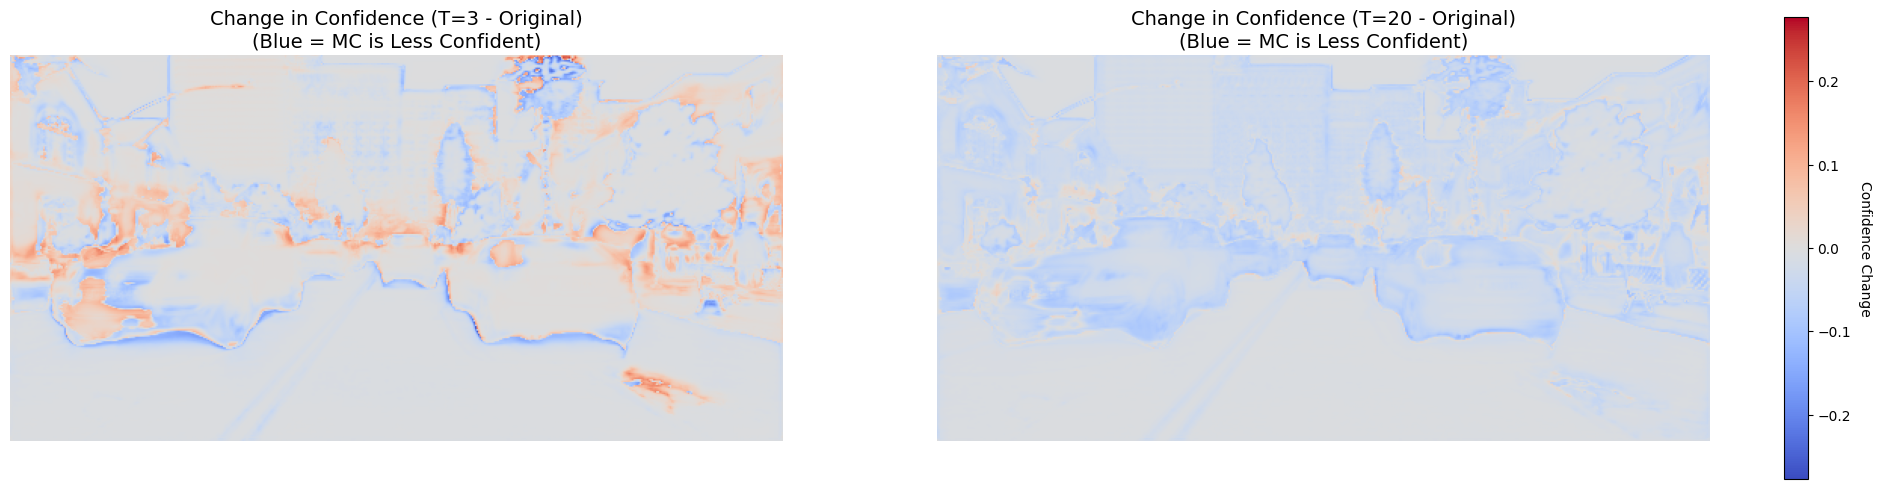

In [ ]:
def get_mc_predictions(wrapper, input_tensor):
    wrapper.eval()
    with torch.no_grad():
        out_mc = wrapper(input_tensor)
        
        if out_mc.dim() == 4: 

            probs = out_mc.softmax(dim=1)
            mean_probs = probs.mean(dim=0)
            
        elif out_mc.dim() == 5:
            probs = out_mc.softmax(dim=2)
            mean_probs = probs.mean(dim=1).squeeze(0)
            
        confidence, _ = mean_probs.max(dim=0)
        
    return confidence.cpu()

def get_deterministic_prediction(model, input_tensor):
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probs = logits.softmax(dim=1)
        confidence, _ = probs.max(dim=1) # [B, H, W] <- AAAAAAAAAAAAA
    return confidence.squeeze(0).cpu()

img_single = img_batch[0].unsqueeze(0).to(device)

conf_original = get_deterministic_prediction(model, img_single)

conf_3 = get_mc_predictions(mc_model_3, img_single)
conf_20 = get_mc_predictions(mc_model_20, img_single)

diff_3 = conf_3 - conf_original
diff_20 = conf_20 - conf_original

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

max_val = max(diff_3.abs().max(), diff_20.abs().max())

# T=3
cax1 = ax1.imshow(diff_3, cmap='coolwarm', vmin=-max_val, vmax=max_val)
ax1.set_title("Change in Confidence (T=3 - Original)\n(Blue = MC is Less Confident)", fontsize=14)
ax1.axis('off')

# T=20
cax2 = ax2.imshow(diff_20, cmap='coolwarm', vmin=-max_val, vmax=max_val)
ax2.set_title("Change in Confidence (T=20 - Original)\n(Blue = MC is Less Confident)", fontsize=14)
ax2.axis('off')

cbar = fig.colorbar(cax2, ax=[ax1, ax2], fraction=0.046, pad=0.04)
cbar.set_label('Confidence Change', rotation=270, labelpad=15)

plt.show()

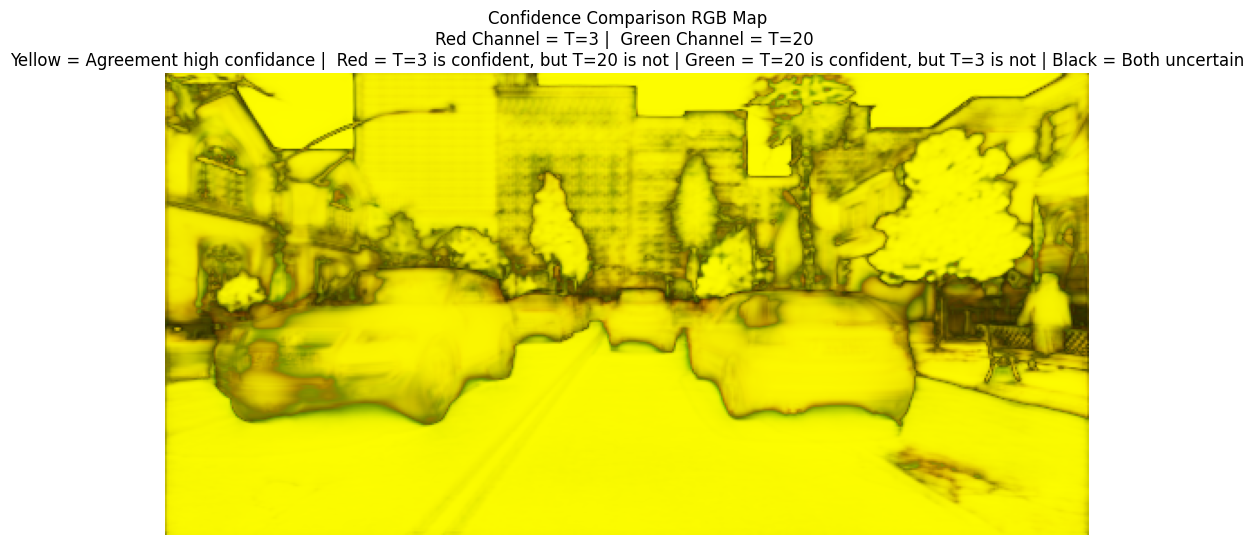

In [91]:
c3 = conf_3.cpu()
c20 = conf_20.cpu()

zeros = torch.zeros_like(c3)

rgb_tensor = torch.stack([c3, c20, zeros], dim=-1)

rgb_img = rgb_tensor.numpy()

plt.figure(figsize=(12, 6))
plt.imshow(rgb_img)

plt.title(
    "Confidence Comparison RGB Map\n"
    "Red Channel = T=3 |  Green Channel = T=20 \n"
    "Yellow = Agreement high confidance |  Red = T=3 is confident, but T=20 is not | Green = T=20 is confident, but T=3 is not | Black = Both uncertain"
)
plt.axis('off')
plt.show()

Calculating confidence stats for T=1 to 20...
T=1: Mean Change=-0.0217, Std=0.0660
T=2: Mean Change=-0.0045, Std=0.0448
T=3: Mean Change=-0.0139, Std=0.0286
T=4: Mean Change=-0.0218, Std=0.0307
T=5: Mean Change=-0.0115, Std=0.0247
T=6: Mean Change=-0.0257, Std=0.0378
T=7: Mean Change=-0.0121, Std=0.0296
T=8: Mean Change=-0.0176, Std=0.0234
T=9: Mean Change=-0.0253, Std=0.0319
T=10: Mean Change=-0.0122, Std=0.0218
T=11: Mean Change=-0.0261, Std=0.0333
T=12: Mean Change=-0.0143, Std=0.0238
T=13: Mean Change=-0.0202, Std=0.0282
T=14: Mean Change=-0.0174, Std=0.0235
T=15: Mean Change=-0.0161, Std=0.0182
T=16: Mean Change=-0.0165, Std=0.0148
T=17: Mean Change=-0.0252, Std=0.0245
T=18: Mean Change=-0.0372, Std=0.0316
T=19: Mean Change=-0.0151, Std=0.0193
T=20: Mean Change=-0.0257, Std=0.0243


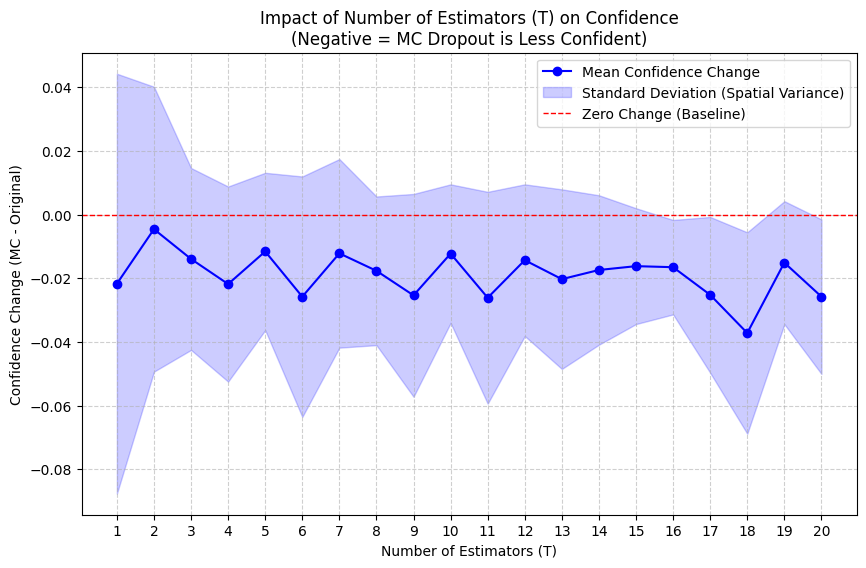

In [94]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gc

# 1. Force the use of a SINGLE image to save memory and match your [H, W] logic
img_single = img_batch[0].unsqueeze(0).to(device)

def get_avg_confidence_change(model, input_tensor, conf_original, T):
    # Free up memory from previous iterations
    torch.cuda.empty_cache()
    gc.collect()
    
    mc_model = mc_dropout(model, num_estimators=T, task="segmentation").to(device)
    
    # --- THE CRITICAL FIX ---
    mc_model.on_batch = False 
    # ------------------------
    
    mc_model.eval()
    
    with torch.no_grad():
        out_mc = mc_model(input_tensor)
    
        if out_mc.dim() == 4: # (Estimators, C, H, W)
            probs = out_mc.softmax(dim=1)
            mean_probs = probs.mean(dim=0)
        elif out_mc.dim() == 5: # (Batch, Estimators, C, H, W)
            probs = out_mc.softmax(dim=2)
            mean_probs = probs.mean(dim=1).squeeze(0)
            
        conf_mc, _ = mean_probs.max(dim=0)
        
    diff = conf_mc - conf_original.to(device)
    
    # Clean up local variables to free memory immediately
    mean_val = diff.mean().item()
    std_val = diff.std().item()
    
    del mc_model, out_mc, probs, mean_probs, conf_mc, diff
    
    return mean_val, std_val

T_values = list(range(1, 21))
means = []
stds = []

# 2. Get the original confidence for the SINGLE image
with torch.no_grad():
    model.eval()
    logits = model(img_single)
    conf_original, _ = logits.softmax(dim=1).max(dim=1)
    conf_original = conf_original.squeeze(0) # [H, W]

print("Calculating confidence stats for T=1 to 20...")

# 3. Run the loop
for t in T_values:
    mu, sigma = get_avg_confidence_change(model, img_single, conf_original, t)
    means.append(mu)
    stds.append(sigma)
    print(f"T={t}: Mean Change={mu:.4f}, Std={sigma:.4f}") # Removed \r so you can see the log history

means = np.array(means)
stds = np.array(stds)

# 4. Plotting
plt.figure(figsize=(10, 6))

plt.plot(T_values, means, marker='o', label='Mean Confidence Change', color='blue')
plt.fill_between(T_values, means - stds, means + stds, color='blue', alpha=0.2, label='Standard Deviation (Spatial Variance)')

plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Change (Baseline)')
plt.xlabel("Number of Estimators (T)")
plt.ylabel("Confidence Change (MC - Original)")
plt.title("Impact of Number of Estimators (T) on Confidence\n(Negative = MC Dropout is Less Confident)")
plt.xticks(T_values)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Try the MC dropout code with a low number of estimators T like 3 and a high number 20, Explain the diffrence seen on the confidence image, is the model getting more confident or less ?**

Both 3 and 20 in average impact negativly the confidance of the model. The difference is that the more is that with T=20, the impact is more smoth around details inside each object, while the T=3 is more concentrated in details and corners of objects. They both do agree very well around the frontiers of objecs and with simple objects (like the sky or the ground), which is very nice.

One interesting thing is that with T=3, it increases the confidence much more then the T=20, and mostly with details of buildings, but both still, just change it a bit.

## E. Uncertainty evaluations with Deep Ensembles
**Q\15 Please implement [Deep Ensembles](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf).**


1.   You need to train 3 DNNs and save it. (Go back to the training cell above and train and save 3 diffrent models)
2.   Use TorchUncertainty to get predictions

You have two options either train several models using the code above or use TU to train the ensemble of models in parallel.

In [95]:
from torch_uncertainty.models import deep_ensembles

In [117]:
import gc
from IPython.display import clear_output

# This was taking ages. So i decided to outsource the training to the beautiful H100 at ensta and just load the models already trained 😊
# Note from the future, the models i trained in the cluster didnt work for some undiscovered reason so i had to train them in my machine anyway.
if False:
    import os
    import gc
    import torch
    import numpy as np
    from torch import nn
    from torch import optim
    from torch.optim import lr_scheduler
    from torch_uncertainty.metrics.segmentation import MeanIntersectionOverUnion

    print("\nStarting Fast Sequential Training for Ensemble Models...\n")
    num_classes = 19
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 50 took too long
    nb_epochs = 30

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), ignore_index=255)

    for model_idx in [2, 3]: # just need two new
        model_save_path = f"models/model_{model_idx}.pth"
        
        print(f"\n{'='*50}")
        print(f"       TRAINING MODEL {model_idx} / 3")
        print(f"{'='*50}\n")
        
        if os.path.exists(model_save_path):
            print(f"Found existing {model_save_path}. Skipping training.")
            continue
            
        # OOM was killing me
        torch.cuda.empty_cache()
        gc.collect()

        model = UNet(classes=num_classes).to(device)

        optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        scheduler = lr_scheduler.StepLR(
            optimizer,
            step_size=lr_decay_epochs,
            gamma=lr_decay
        )

        metric = MeanIntersectionOverUnion(num_classes=num_classes, ignore_index=255).to(device)

        train_loss_history = []
        train_miou_history = []

        for epoch in range(nb_epochs):
            print(f"Model {model_idx} - Epoch {epoch + 1}/{nb_epochs}")

            # --- TRAINING ONLY ---
            t_loss, t_iou_class, t_miou = train(model, train_loader, optimizer, criterion, metric)
            
            train_loss_history.append(t_loss)
            train_miou_history.append(t_miou.item())

            print(f"--> Train Loss: {t_loss:.4f} | Train mIoU: {t_miou.item():.2%}")

            scheduler.step()

        print(f"\nSaving final weights to {model_save_path} ...\n")
        torch.save(model.state_dict(), model_save_path)

        print(f"Training complete for Model {model_idx}. Final Train mIoU: {t_miou.item():.2%}\n")

    print("\nAll requested models have been trained and saved successfully!")
else:
    import glob
    import torch
    from einops import rearrange

    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_classes = 19

    model_paths = sorted(glob.glob("models/model_*.pth"))
    num_estimators = len(model_paths)
    print(f"Found {num_estimators} models.")

    loaded_core_models = []
    for path in model_paths:
        model = UNet(classes=num_classes).to(device)
        state_dict = torch.load(path, map_location=device)
        
        new_state_dict = {}
        for k, v in state_dict.items():
            new_key = k
            if k.startswith('inc.conv.') and not k.startswith('inc.conv.conv.'):
                new_key = k.replace('inc.conv.', 'inc.conv.conv.')
            elif k.startswith('outc.') and not k.startswith('outc.conv.'):
                new_key = k.replace('outc.', 'outc.conv.')
            new_state_dict[new_key] = v
            
        model.load_state_dict(new_state_dict, strict=False)
        loaded_core_models.append(model)

    ensemble = deep_ensembles(
        core_models=loaded_core_models,
        task="segmentation"
    ).to(device)

    ensemble.eval()
    print("Deep Ensemble successfully loaded using deep_ensembles.py!")

Found 3 models.
Deep Ensemble successfully loaded using deep_ensembles.py!


In [118]:
import torch
from torch_uncertainty.metrics.segmentation import MeanIntersectionOverUnion
from einops import rearrange
from tqdm import tqdm

print("--- DIAGNOSTIC EVALUATION ---")

# 1. Let's strictly check the weight loading of the FIRST model to see if keys are missing
path = model_paths[0]
test_model = UNet(classes=19).to(device)
state_dict = torch.load(path, map_location=device)

new_state_dict = {}
for k, v in state_dict.items():
    new_key = k
    if k.startswith('inc.conv.') and not k.startswith('inc.conv.conv.'):
        new_key = k.replace('inc.conv.', 'inc.conv.conv.')
    elif k.startswith('outc.') and not k.startswith('outc.conv.'):
        new_key = k.replace('outc.', 'outc.conv.')
    new_state_dict[new_key] = v

print("Checking Model 1 Key Matching:")
# We capture the output of load_state_dict to see EXACTLY what was skipped
incompatible_keys = test_model.load_state_dict(new_state_dict, strict=False)
if len(incompatible_keys.missing_keys) > 0:
    print(f"⚠️ WARNING - Missing Keys: {incompatible_keys.missing_keys}")
else:
    print("✅ All weights loaded perfectly!")

print("\n--- Running Evaluation on Validation Set (First 10 Batches) ---")

# 2. Evaluate each loaded model
for i, model in enumerate(loaded_core_models):
    model.eval()
    metric = MeanIntersectionOverUnion(num_classes=19, ignore_index=255).to(device)
    
    pixel_correct = 0
    pixel_total = 0
    
    with torch.no_grad():
        # Loop through a subset of the validation loader
        for batch_idx, (imgs, targets) in enumerate(val_loader):
            imgs = imgs.to(device)
            targets = targets.to(device).squeeze(1)
            
            logits = model(imgs)
            preds = logits.argmax(dim=1)
            
            # Flatten for metric calculations
            flat_logits = rearrange(logits, "b c h w -> (b h w) c")
            flat_targets = targets.flatten()
            mask = flat_targets != 255  # Ignore index
            
            # Update mIoU
            metric.update(flat_logits[mask], flat_targets[mask])
            
            # Update Pixel Accuracy
            pixel_correct += (preds.flatten()[mask] == flat_targets[mask]).sum().item()
            pixel_total += mask.sum().item()
            
            # Break after 10 batches to keep this test fast
            if batch_idx >= 9:
                break

    acc = pixel_correct / pixel_total
    err_rate = 1.0 - acc
    miou = metric.compute().item()
    
    print(f"Model {i+1} | Pixel Acc: {acc:.2%} (Error: {err_rate:.2%}) | mIoU: {miou:.4f}")

--- DIAGNOSTIC EVALUATION ---
Checking Model 1 Key Matching:
✅ All weights loaded perfectly!

--- Running Evaluation on Validation Set (First 10 Batches) ---
Model 1 | Pixel Acc: 86.69% (Error: 13.31%) | mIoU: 0.4698
Model 2 | Pixel Acc: 85.64% (Error: 14.36%) | mIoU: 0.4161
Model 3 | Pixel Acc: 85.48% (Error: 14.52%) | mIoU: 0.4151


In [103]:
# Get a test image
sample_idx = 15
img, target = val_set[sample_idx]
batch_img = img.unsqueeze(0).to(device)

with torch.no_grad():
    # 1. Forward pass through the ensemble wrapper
    # Returns shape: (N * B, C, H, W)
    logits = ensemble(batch_img)
    
    # 2. Reshape to separate the models and the batch: (N, B, C, H, W)
    # Since B=1 here, it becomes (3, 1, 19, 256, 512)
    logits = rearrange(logits, "(n b) c h w -> n b c h w", n=num_estimators)
    
    # 3. Convert logits to probabilities (Dim 2 is classes)
    probs = torch.softmax(logits, dim=2) 
    
    # 4. Final Prediction (Mean of probabilities)
    ens_probs = probs.mean(dim=0).squeeze(0) # (C, H, W)
    ens_pred_class = ens_probs.argmax(dim=0) # (H, W)
    
    # 5. Epistemic Uncertainty (Variance across the models)
    variance = probs.var(dim=0).mean(dim=1).squeeze(0)

print("Inference successful! Ready to plot.")

Inference successful! Ready to plot.


Test your ensemble obtained either using option 1 or 2.

Running inference through the Ensemble wrapper...


/tmp/ipykernel_920/1896070504.py:120: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


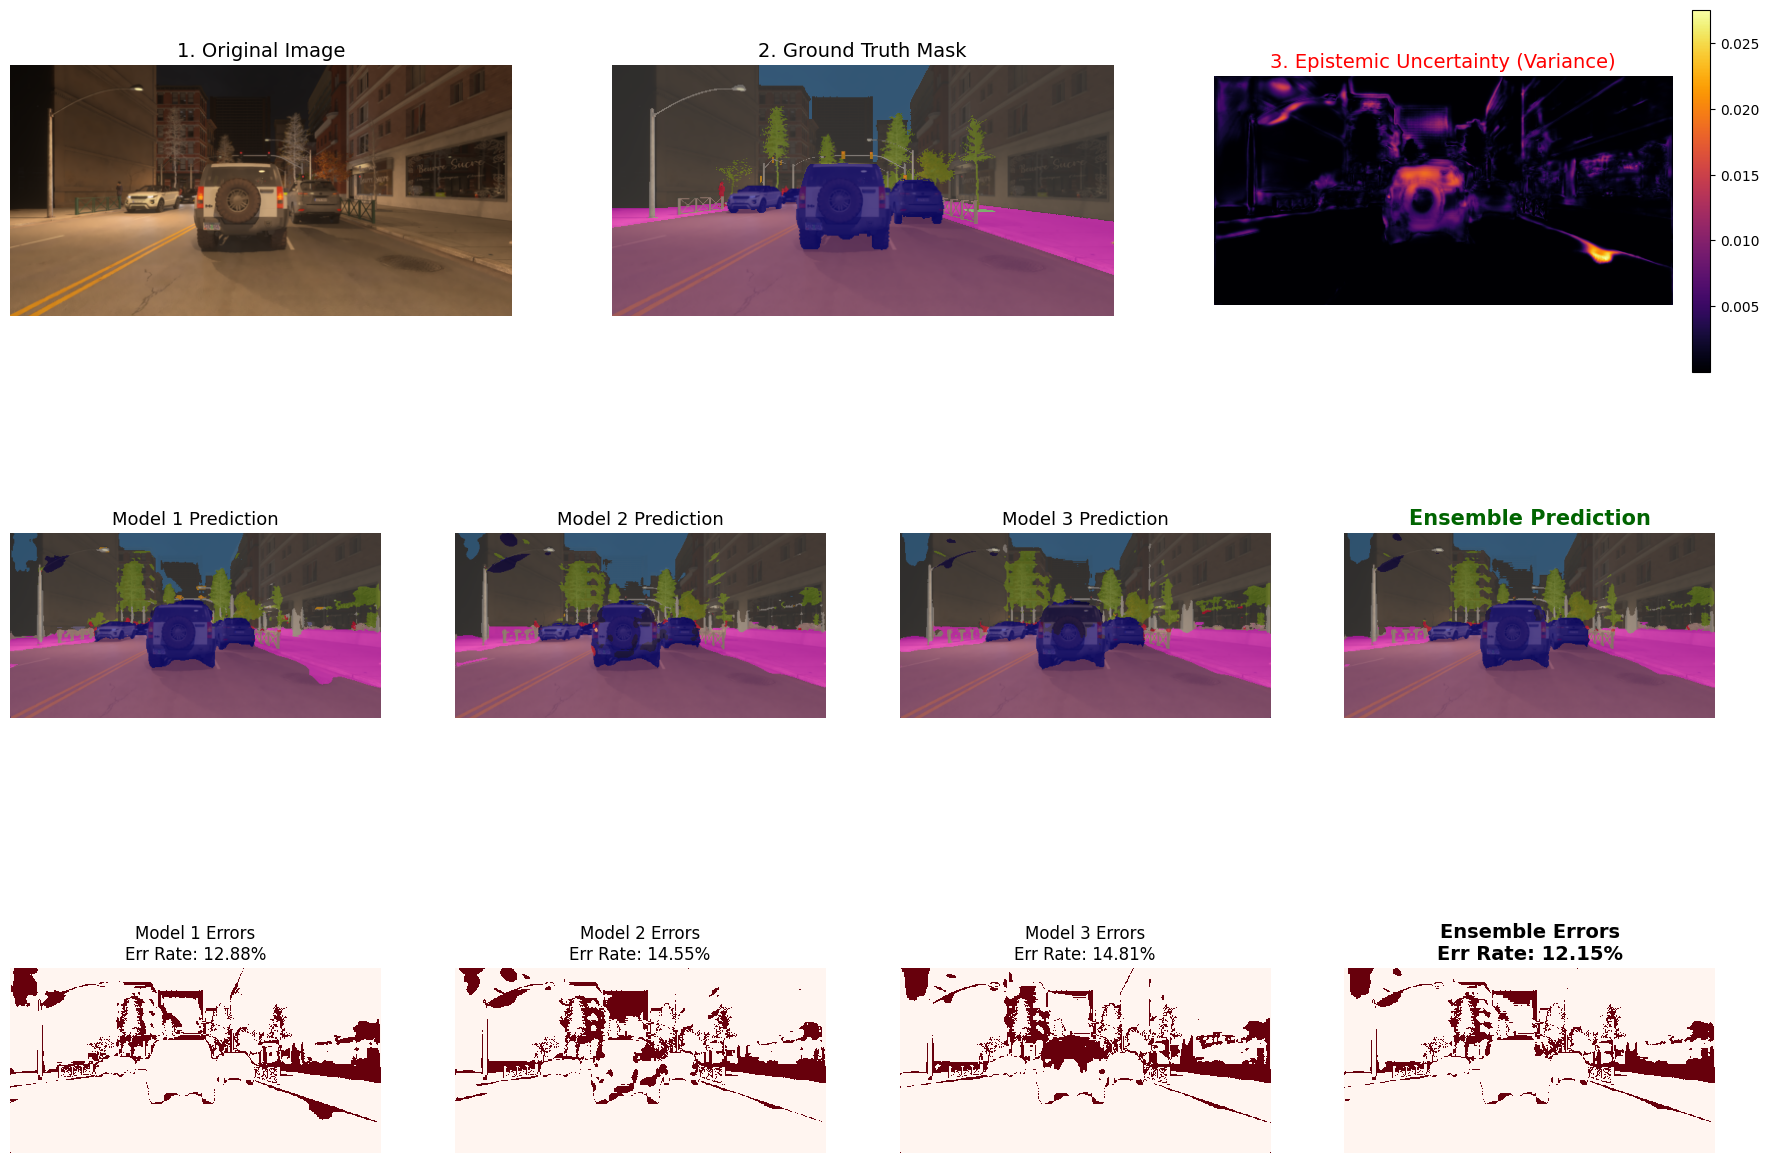

In [119]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.v2.functional as F
from einops import rearrange

# 1. Select a sample
sample_idx = 15  # Feel free to change this!
img, target = val_set[sample_idx]
img_single = img.unsqueeze(0).to(device)
target = target.to(device).squeeze(0)

# 2. Run Inference using the deep_ensembles wrapper
print("Running inference through the Ensemble wrapper...")
with torch.no_grad():
    # Forward pass returns shape: (N * B, C, H, W)
    logits = ensemble(img_single)
    
    # Reshape to separate models (N) and batch (B) -> (N, B, C, H, W)
    logits = rearrange(logits, "(n b) c h w -> n b c h w", n=num_estimators)
    
    # Convert to probabilities
    probs = torch.softmax(logits, dim=2)
    
    # Extract the first 3 individual model predictions (Shape: 3, H, W)
    indiv_preds = probs[:3].argmax(dim=2).squeeze(1)
    
    # Calculate Ensemble Prediction (Mean across all N estimators)
    ens_probs = probs.mean(dim=0).squeeze(0) # (C, H, W)
    ens_pred = ens_probs.argmax(dim=0)       # (H, W)
    
    # Calculate Epistemic Uncertainty (Variance across all N estimators)
    variance = probs.var(dim=0).mean(dim=1).squeeze(0).cpu().numpy()

# 3. Prepare Image and Masks for Overlay Display
mean_tensor = torch.tensor([0.485, 0.456, 0.406], device=img_single.device)
std_tensor = torch.tensor([0.229, 0.224, 0.225], device=img_single.device)
img_disp = img_single[0] * std_tensor[:, None, None] + mean_tensor[:, None, None]
img_disp = F.to_dtype(img_disp, torch.uint8, scale=True)

palette = val_set.color_palette if hasattr(val_set, 'color_palette') else None
num_classes = 19
classes_indices = torch.arange(num_classes, device=device)[:, None, None]

# Helper function to generate overlays exactly as you requested
def get_overlay_pil(pred_tensor):
    pred_masks = pred_tensor == classes_indices
    overlay = draw_segmentation_masks(img_disp, pred_masks, alpha=0.6, colors=palette)
    return F.to_pil_image(overlay)

# Generate PIL images for display
img_pil = F.to_pil_image(img_disp)
gt_masks = target == classes_indices
gt_overlay_pil = F.to_pil_image(draw_segmentation_masks(img_disp, gt_masks, alpha=0.6, colors=palette))

indiv_overlay_pils = [get_overlay_pil(indiv_preds[i]) for i in range(3)]
ens_overlay_pil = get_overlay_pil(ens_pred)

# 4. Setup Error Maps
valid_pixels = target != 255  # Ignore index 255 for error calculation

# Calculate binary error maps (1 if wrong, 0 if correct or ignored)
indiv_errors = [((indiv_preds[i] != target) & valid_pixels).cpu().numpy().astype(float) for i in range(3)]
ens_error = ((ens_pred != target) & valid_pixels).cpu().numpy().astype(float)
valid_pixels_count = valid_pixels.sum().item()

# 5. Plotting the Comparison Grid
fig = plt.figure(figsize=(22, 16))

# --- ROW 1: Context ---
ax1 = plt.subplot(3, 3, 1)
ax1.imshow(img_pil)
ax1.set_title("1. Original Image", fontsize=14)
ax1.axis('off')

ax2 = plt.subplot(3, 3, 2)
ax2.imshow(gt_overlay_pil)
ax2.set_title("2. Ground Truth Mask", fontsize=14)
ax2.axis('off')

ax3 = plt.subplot(3, 3, 3)
cax = ax3.imshow(variance, cmap='inferno')
ax3.set_title("3. Epistemic Uncertainty (Variance)", fontsize=14, color='red')
ax3.axis('off')
fig.colorbar(cax, ax=ax3, fraction=0.046, pad=0.04)

# --- ROW 2: Predictions (Overlay method) ---
titles = ["Model 1 Prediction", "Model 2 Prediction", "Model 3 Prediction", "Ensemble Prediction"]
preds_to_plot = [indiv_overlay_pils[0], indiv_overlay_pils[1], indiv_overlay_pils[2], ens_overlay_pil]

for i in range(4):
    ax = plt.subplot(3, 4, 5 + i)
    ax.imshow(preds_to_plot[i])
    
    if i == 3:
        ax.set_title(titles[i], fontsize=15, fontweight='bold', color='darkgreen')
    else:
        ax.set_title(titles[i], fontsize=13)
    ax.axis('off')

# --- ROW 3: Error Maps (Showing the Improvement) ---
error_titles = ["Model 1 Errors", "Model 2 Errors", "Model 3 Errors", "Ensemble Errors"]
errors_to_plot = [indiv_errors[0], indiv_errors[1], indiv_errors[2], ens_error]

for i in range(4):
    ax = plt.subplot(3, 4, 9 + i)
    # Plot errors in red, correct pixels as transparent/white
    ax.imshow(errors_to_plot[i], cmap='Reds', interpolation='nearest', vmin=0, vmax=1)
    
    # Calculate error percentage for the title
    err_pct = (errors_to_plot[i].sum() / valid_pixels_count) * 100
    
    if i == 3:
        ax.set_title(f"{error_titles[i]}\nErr Rate: {err_pct:.2f}%", fontsize=14, fontweight='bold')
    else:
        ax.set_title(f"{error_titles[i]}\nErr Rate: {err_pct:.2f}%", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

Save the ensemble model

In [120]:
final_model_path = "ensemble.pth"
torch.save(ensemble.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

Model saved to ensemble.pth


## F. Uncertainty evaluations with Packed-Ensembles
**Q\15 Please read [Packed-Ensembles](https://arxiv.org/pdf/2210.09184). Then Implement a Packed-Ensembles Unet and train it and evaluate its Uncertainty**


In [ ]:
import torch
from torch import nn, optim
from torch_uncertainty.models.segmentation.unet import packed_small_unet
from tqdm import tqdm

print("--- Initializing Packed-Ensemble UNet ---")

num_classes = 19
num_estimators = 4  
device = "cuda" if torch.cuda.is_available() else "cpu"

pe_model = packed_small_unet(
    in_channels=3, 
    num_classes=num_classes, 
    alpha=2, 
    num_estimators=num_estimators, 
    gamma=1
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.AdamW(pe_model.parameters(), lr=0.001)

# Fast Training Loop
epochs = 10
pe_model.train()

print(f"Training Packed-Ensemble with {num_estimators} estimators...")

for epoch in range(epochs):
    epoch_loss = 0.0
    
    # --- ADD TQDM PROGRESS BAR HERE ---
    # We wrap the train_loader so it displays a progress bar for the batches
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    
    for batch_idx, (imgs, targets) in enumerate(pbar):
        imgs = imgs.to(device)
        targets = targets.to(device).squeeze(1) # Shape: (B, H, W)
        
        # Repeat targets so they match the stacked output of the PE model
        targets_repeated = targets.repeat(num_estimators, 1, 1)
        
        optimizer.zero_grad()
        
        # Forward pass: returns (B * num_estimators, C, H, W)
        logits = pe_model(imgs)
        
        loss = criterion(logits, targets_repeated)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Dynamically update the progress bar text with the running loss!
        pbar.set_postfix({"Loss": f"{epoch_loss / (batch_idx + 1):.4f}"})

print("\nSaving Packed-Ensemble model...")
torch.save(pe_model.state_dict(), "packed_ensemble.pth")
print("Training complete and model saved!")

--- Initializing Packed-Ensemble UNet ---
Training Packed-Ensemble with 4 estimators...


Epoch 1/10:   2%|▎         | 1/40 [00:54<35:22, 54.43s/batch, Loss=2.9224]

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.v2.functional as F
from einops import rearrange
import numpy as np

print("--- Evaluating Uncertainty ---")
pe_model.eval()

sample_idx = 15
img, target = val_set[sample_idx]
img_single = img.unsqueeze(0).to(device)

with torch.no_grad():
    # (1 * 4, C, H, W)
    logits = pe_model(img_single)
    
    # (4, 1, C, H, W)
    logits = rearrange(logits, "(n b) c h w -> n b c h w", n=num_estimators)
    
    probs = torch.softmax(logits, dim=2)
    
    ens_probs = probs.mean(dim=0).squeeze(0) # (C, H, W)
    ens_pred = ens_probs.argmax(dim=0).cpu().numpy()       
    
    variance = probs.var(dim=0).mean(dim=1).squeeze(0).cpu().numpy()

mean_tensor = torch.tensor([0.485, 0.456, 0.406], device=img_single.device)
std_tensor = torch.tensor([0.229, 0.224, 0.225], device=img_single.device)
img_disp = img_single[0] * std_tensor[:, None, None] + mean_tensor[:, None, None]
img_disp = F.to_dtype(img_disp, torch.uint8, scale=True)

import matplotlib.colors as mcolors
cmap = plt.get_cmap('tab20', 19)
norm = mcolors.BoundaryNorm(np.arange(-0.5, 19.5, 1), cmap.N)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.imshow(F.to_pil_image(img_disp))
ax1.set_title("Original Image", fontsize=14)
ax1.axis('off')

ax2.imshow(ens_pred, cmap=cmap, norm=norm, interpolation='nearest')
ax2.set_title("Packed-Ensemble Prediction", fontsize=14)
ax2.axis('off')

cax = ax3.imshow(variance, cmap='inferno')
ax3.set_title("Packed Epistemic Uncertainty", fontsize=14, color='red')
ax3.axis('off')
fig.colorbar(cax, ax=ax3, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

**Please conclude your report**